# Titanic with analysis and grid search
reference: [Titanic top 4% with ensemble modeling](https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling)<br>
* grid search
* normal voting
* dummy variables

In [78]:
import pandas as pd
import numpy as np
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import seaborn as sb
import json
from sklearn.metrics import r2_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

In [186]:
CORE_COUNT = 2
ONLY_PREDICT = True

SEED = 180
NFOLDS = 10

In [187]:
config = {}

In [188]:
config["show_visual"] = False

In [189]:
config["use_drop_num_outliner"] = False  # 不适用outliner detection

config["data_dropped"] = False
config["replace_title_to_rare"] = False
config["title_to_ordinal"] = False
config["converting_sex_feature"] = False
config["create_family_size"] = False
config["converting_embark_feature"] = False

# Load data

In [190]:
ttrain = pd.read_csv("train.csv")
ttest = pd.read_csv("test.csv")
label_column = "Survived"
print("Data loaded.")

Data loaded.


# Data overview

In [191]:
if not ONLY_PREDICT:
    print(ttrain.columns.values)
    print(len(ttrain.columns.values))

    print(ttest.columns.values)
    print(len(ttest.columns.values))

In [192]:
if not ONLY_PREDICT:
    for c in ttrain.columns:
        d = ttrain[c]
        du = d.unique()
        print(c + ".unique = ", len(du))

In [193]:
ttrain.head()

# no use: PassengerId
# string: Name, Ticket, Cabin
# categorical: Sex, Embarked, Pclass
# numerical: Age, SibSp, Parch, Fare
    # SibSp, Parch: can be treated as categorical
# label = Survived

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [194]:
# ttrain.describe(include='O')

In [195]:
# ttrain.describe(include=np.number)

In [196]:
if not ONLY_PREDICT:
    ttrain.info()
    print('_'*40)
    ttest.info()

# Outliner detection
Since outliers can have a dramatic effect on the prediction (espacially for regression problems), i choosed to manage them.<br>
<br>
I used the Tukey method (Tukey JW., 1977) to detect ouliers which defines an interquartile range comprised between the 1st and 3rd quartile of the distribution values (IQR——四分位数间距). An outlier is a row that have a feature value outside the (IQR +- an outlier step).<br>
定义outliner是数值超过分布的四分位数间距 +- outliner step的值。Tukey method<br>
<br>
I decided to detect outliers from the numerical values features (Age, SibSp, Parch and Fare). Then, i considered outliers as rows that have at least two outlied numerical values.<br>
选择数值feature，在row中，如果有超过两个outliner值，则将row作为outliner<br>

In [197]:
# Outlier detection 
from collections import Counter

def detect_outliers(df, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col], 75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
# 数值类型的feature只有如下四个。
Outliers_to_drop = detect_outliers(ttrain1, 2, ["Age", "SibSp", "Parch", "Fare"])

if not ONLY_PREDICT:
    print(Outliers_to_drop)
    
if not ONLY_PREDICT:
    # Show the outliers rows
    ttrain1.loc[Outliers_to_drop]

/usr/local/lib/python3.6/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


但是个人认为，这四个feature并不像采样数据，这是真实情况的反应，所以不存在measurement error<br>
Fare数据跨度大，skewness较大，可以使用np.log<br>
Age需要用合适的方式处理缺失值。<br>
SibSp和Parch虽然skewness也很大，但是数值是离散分布，可以按照Categorical方式处理分类<br>

In [198]:
if not ONLY_PREDICT:
    # column_name = "Age"
    # column_name = "SibSp"
    # column_name = "Parch"
    column_name = "Fare"
    a = ttrain[column_name].dropna()
    print(a.describe())
    print("-"*10)
    print(a.isnull().sum())
    print("-"*10)
    print(a.skew())

    g = sb.distplot(a)

In [199]:
# Drop outliers
if config.get("use_drop_num_outliner"):
    ttrain1 = ttrain1.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)
    print("use_drop_num_outliner")

# Concatenate train and test

In [200]:
import copy
ttrain1 = copy.deepcopy(ttrain)
ttest1 = copy.deepcopy(ttest)

In [201]:
dataall = pd.concat(objs=[ttrain1, ttest1], axis=0, sort=False).reset_index(drop=True)
dataall = dataall.fillna(np.nan)
if not ONLY_PREDICT:
    print(dataall.info())
    print("--"*20)
    print(dataall.isnull().sum())

missing values:<br>
* Age=263
* Fare=1
* Cabin=1014
* Embarked=2

# Feature Analysis

### Pclass

In [202]:
if config.get("show_visual"):
    for x in ttrain["Pclass"].unique(): 
        ttrain1["Age"][ttrain["Pclass"] == x].plot(kind="kde", label="Pclass: {}".format(x))
    plt.legend()

### Correlationship in numerical features

In [203]:
if config.get("show_visual"):
    plt.figure(figsize=(8,6))
    plt.title('Pearson Correlation of Features', y=1.05, size=15)
    sb.heatmap(dataall[["Survived", "Age", "SibSp", "Parch", "Fare"]].corr(),  # 数据tab
               linewidths=0.1,
               vmax=1.0,  # 值范围
               square=True, 
               cmap="coolwarm", 
               linecolor="white",  # 间隔线
               annot=True)  # 是否显示具体数值

# 只有Fare=0.26，和label相关些

### SibSp

In [204]:
if config.get("show_visual"):
    g = sb.catplot(x="SibSp",y="Survived",data=dataall,kind="bar", height=6, palette="muted")
    g.despine(left=True)
    g = g.set_ylabels("survival probability")
    print(dataall["SibSp"].groupby(dataall["SibSp"]).count())

### Age

In [205]:
# Explore Age distibution 
if config.get("show_visual"):
    g = sb.kdeplot(ttrain1["Age"][(ttrain1["Survived"] == 0) & (ttrain1["Age"].notnull())], color="Red", shade=True)
    g = sb.kdeplot(ttrain1["Age"][(ttrain1["Survived"] == 1) & (ttrain1["Age"].notnull())], ax=g, color="Blue", shade=True)
    g.set_xlabel("Age")
    g.set_ylabel("Frequency")
    g = g.legend(["Not Survived","Survived"])

# 观察peak

### Fare

In [206]:
# Fare有一个缺失值
if not ONLY_PREDICT:
    print(dataall["Fare"].isnull().sum())
dataall["Fare"] = dataall["Fare"].fillna(dataall["Fare"].median())

In [207]:
if config.get("show_visual"):
    g = sb.distplot(dataall["Fare"], color="m", label="Skewness : %.2f"%(dataall["Fare"].skew()))
    g = g.legend(loc="best")

# fare的值偏度很大，会对模型产生影响。使用log值减小偏度

### Sex

In [208]:
# Explore Pclass vs Survived by Sex
if config.get("show_visual"):
    g = sb.catplot(x="Pclass", y="Survived", hue="Sex", data=ttrain1, height=6, kind="bar", palette="muted")
    g = g.set_ylabels("survival probability")

In [209]:
dataall.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Feature engineering

### Fare

In [210]:
def make_fare_to_log(d):
    d["Fare"] = d["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

In [211]:
if not config.get("make_fare_to_log"):
    make_fare_to_log(dataall)
    config["make_fare_to_log"] = True
    print("make_fare_to_log")

make_fare_to_log


In [212]:
if config.get("show_visual"):
    g = sb.distplot(dataall["Fare"], color="b", label="Skewness : %.2f"%(dataall["Fare"].skew()))
    g = g.legend(loc="best")

### Name/Title

In [213]:
# 提取title
def extract_title(d):
    d["Title"] = d["Name"].str.extract(' ([A-Za-z]+)\.', expand=False)

In [214]:
extract_title(dataall)
if not ONLY_PREDICT:
    dataall["Title"].head()

In [215]:
if not ONLY_PREDICT:
    pd.crosstab(dataall['Title'], dataall["Sex"])

In [216]:
rare_titles = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
def replace_title_to_rare(dataset):
    dataset['Title'] = dataset['Title'].replace(rare_titles, 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
# dataall["Title"].groupby(dataall["Title"]).count()

In [217]:
if not config.get("replace_title_to_rare"):
    replace_title_to_rare(dataall)
    config["replace_title_to_rare"] = True

In [218]:
if not ONLY_PREDICT:
    dataall['Title'].groupby(dataall["Title"]).count()

In [219]:
if config.get("show_visual"):
    g = sb.catplot(x="Title", y="Survived", data=dataall, kind="bar")
    g = g.set_xticklabels(["Master", "Miss", "Mrs", "Mr", "Rare"])
    g = g.set_ylabels("survival probability")

In [220]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
def title_to_ordinal(dataset):
    dataset['Title'] = dataset['Title'].map(title_mapping).astype(np.int32)
    dataset['Title'] = dataset['Title'].fillna(0)

In [221]:
if not config.get("title_to_ordinal"):
    title_to_ordinal(dataall)
    config["title_to_ordinal"] = True
    print("title_to_ordinal")

title_to_ordinal


In [222]:
if not ONLY_PREDICT:
    dataall['Title'].groupby(dataall["Title"]).count()

### Creating FamilySize

In [223]:
def create_family_size(dataset):
    dataset["FamilySize"] = dataset["SibSp"] + dataset["Parch"] + 1

In [224]:
if not config.get("create_family_size"):
    create_family_size(dataall)
    config["create_family_size"] = True
    print("create_family_size")
    
if not ONLY_PREDICT:
    dataall[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

create_family_size


In [225]:
if config.get("show_visual"):
    g = sb.catplot(x="FamilySize", y="Survived", data=dataall, kind="bar")
    g = g.set_ylabels("Survival Probability")

### Converting Embark

In [226]:
dataall["Embarked"].groupby(dataall['Embarked']).count()

Embarked
C    270
Q    123
S    914
Name: Embarked, dtype: int64

In [227]:
def converting_embark_feature(dataset):
    dataset["Embarked"] = dataset["Embarked"].fillna(dataset["Embarked"].dropna().mode().iloc[0])
    dataset['Embarked'] = dataset['Embarked'].map({"Q": 2, 'S': 1, 'C': 0}).astype(int)

In [228]:
if not config.get("converting_embark_feature"):
    converting_embark_feature(dataall)
    config["converting_embark_feature"] = True
    print("converting_embark_feature")

converting_embark_feature


In [229]:
dataall['Embarked'].groupby(dataall["Embarked"]).count()

Embarked
0    270
1    916
2    123
Name: Embarked, dtype: int64

### Cabin

In [230]:
def convert_cabin_to_category(dataset):
    dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ])

In [231]:
# dataall['Cabin'].groupby(dataall["Cabin"]).count()
if not config.get("convert_cabin_to_category"):
    convert_cabin_to_category(dataall)
    config["convert_cabin_to_category"] = True
    
dataall['Cabin'].groupby(dataall["Cabin"]).count()

Cabin
A      22
B      65
C      94
D      46
E      41
F      21
G       5
T       1
X    1014
Name: Cabin, dtype: int64

In [232]:
if not config.get("convert_cabin_to_num"):
    dataall['Cabin'] = dataall['Cabin'].map({
        "B": 2, 'A': 1, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 8, 'X': 9}).astype(int)
    config["convert_cabin_to_num"] = True
    
dataall['Cabin'].groupby(dataall["Cabin"]).count()

Cabin
1      22
2      65
3      94
4      46
5      41
6      21
7       5
8       1
9    1014
Name: Cabin, dtype: int64

### Ticket

In [233]:
def convert_ticket(d):
    res = pd.Series(np.zeros(d["Ticket"].shape))
    for i in range(len(d["Ticket"])):
        v = d["Ticket"].iloc[i]
        if v.isdigit():
            res[i] = "Num"
        else:
            res[i] = v.split(" ")[0].split("/")[0].split(".")[0]
            
        if res[i] in ("P", "PP"):
            res[i] = "PC"
#         elif res[i] in ("A4", "AQ"):
#             res[i] = "A"
        elif res[i] in ("Fa"):
            res[i] = "F"
        elif res[i] in ("SCO", "SO"):
            res[i] = "SC"
#         elif res[i] in ("W"):
#             res[i] = "WE"
#         elif res[i] in ("LINE", "LP", "SW"):
        elif res[i] in ("LINE", "LP", "SW", "A", "A4", "AQ", "S", "CA", "W", "WE", "SOTON"):
            res[i] = "RARE"
    return res

In [234]:
res = convert_ticket(dataall)
if not ONLY_PREDICT:
    print(res.groupby(res).count())
dataall["NewTicket"] = res

In [235]:
if config.get("show_visual"):
    g = sb.catplot(x="NewTicket", y="Survived", data=dataall, kind="bar")
    g = g.set_ylabels("Survival Probability")

In [236]:
if not config.get("convert_ticket_to_num"):
    dataall['NewTicket'] = dataall['NewTicket'].map({
        "PC": 2, 'RARE': 1, 'STON': 3, 'Num': 4, 'C': 5, 'F': 6, 'SC': 7}).astype(int)
    config["convert_ticket_to_num"] = True
    print("convert_ticket_to_num")
    
print(dataall['NewTicket'].groupby(dataall['NewTicket']).count())

convert_ticket_to_num
NewTicket
1    137
2     98
3     22
4    957
5     55
6     13
7     27
Name: NewTicket, dtype: int64


### Sex

In [237]:
def converting_sex_feature(dataset):
    dataset['Sex'] = dataset['Sex'].map({'female': 1, 'male': 0}).astype(np.int32)

In [238]:
if not ONLY_PREDICT:
    print(dataall["Sex"].isnull().sum())
    dataall['Sex'].groupby(dataall["Sex"]).count()

In [239]:
if not config.get("converting_sex_feature"):
    converting_sex_feature(dataall)
    config["converting_sex_feature"] = True
    print("converting_sex_feature")

converting_sex_feature


In [240]:
dataall['Sex'].groupby(dataall["Sex"]).count()

Sex
0    843
1    466
Name: Sex, dtype: int64

### Fill nan in  Age
Age缺失很多，不能直接简单的用median代替<br>

In [241]:
dataall.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,NewTicket
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,1.981001,9,1,1,2,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,4.266662,3,0,3,2,2
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,2.070022,9,1,2,1,3
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,3.972177,3,1,3,2,4
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,2.085672,9,1,1,1,4


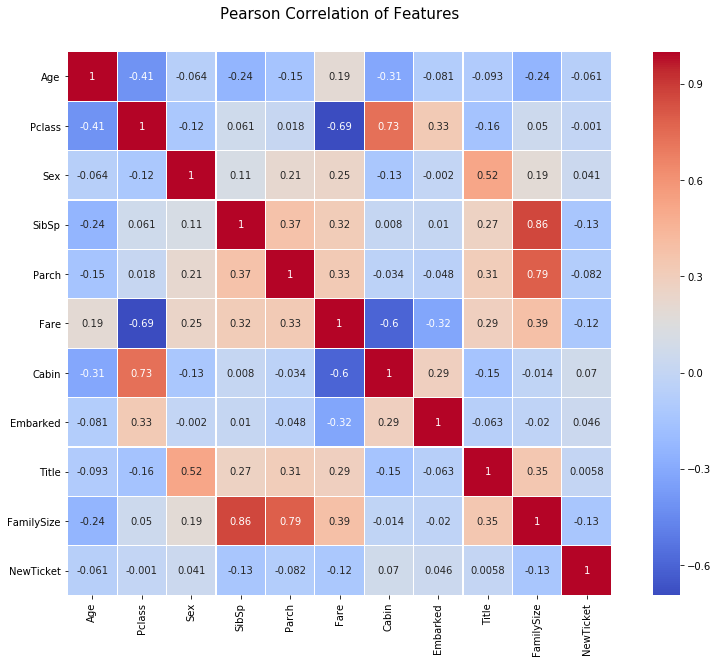

In [242]:
plt.figure(figsize=(15,10))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sb.heatmap(dataall[["Age", "Pclass", "Sex", "SibSp", "Parch", "Fare", "Cabin", 
                   "Embarked", "Title", "FamilySize", "NewTicket"]].corr(),  # 数据tab
           linewidths=0.1,
           vmax=1.0,  # 值范围
           square=True, 
           cmap="coolwarm", 
           linecolor="white",  # 间隔线
           annot=True)  # 是否显示具体数值

# Pclass, SibSp, Parch, Fare, Cabin, FamilySize > 0.1

In [243]:
# 这里的思路是，对于缺失的age，如果可以找到相同的SibSp、Parch、Pclass，则使用它们的median，否则使用整体的median
# Pclass, SibSp, Parch, Fare, Cabin, FamilySize

def guess_age(dataset):
    index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)
    count = 0
    age_med = dataset["Age"].median()
    for i in index_NaN_age:
        try:
            age_pred = dataset["Age"][(
                (dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & 
                (dataset['Parch'] == dataset.iloc[i]["Parch"]) & 
                (dataset['Pclass'] == dataset.iloc[i]["Pclass"]) &
                (abs(dataset['Fare'] - dataset.iloc[i]["Fare"]) < 50) &
                (dataset["Cabin"] == dataset.iloc[i]["Cabin"]) &
                (dataset["FamilySize"] == dataset.iloc[i]["FamilySize"])
            )].median()
        except:
            age_pred = np.nan
        
        if not np.isnan(age_pred):
            count += 1
            dataset['Age'].iloc[i] = age_pred
        else:
            dataset['Age'].iloc[i] = age_med
    
    print("total missing count =", len(index_NaN_age), ", find pred count =", count)
    # dataset['Age'] = dataset['Age'].astype(int)

In [244]:
if not config.get("guess_age"):
    guess_age(dataall)
    config["guess_age"] = True
    print("guess_age")

# 256个缺失中，有255个找到了对应的median

/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


total missing count = 263 , find pred count = 261


In [245]:
# dataall["Age"] = np.hstack([ttrain["Age"], ttest["Age"]])
# print(dataall["Age"].isnull().sum())

### Dummy categories

In [246]:
dataall.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Title,FamilySize,NewTicket
count,1309.000000,891.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,655.000000,0.383838,2.294882,0.355997,29.178892,0.498854,0.385027,2.910408,7.729565,0.887701,1.732620,1.883881,3.643239
std,378.020061,0.486592,0.837836,0.478997,13.266469,1.041658,0.865560,1.003886,2.454520,0.536505,1.022087,1.583639,1.182955
min,1.000000,0.000000,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,328.000000,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,2.066331,9.000000,1.000000,1.000000,1.000000,4.000000
50%,655.000000,0.000000,3.000000,0.000000,26.000000,0.000000,0.000000,2.670985,9.000000,1.000000,1.000000,1.000000,4.000000
75%,982.000000,1.000000,3.000000,1.000000,36.000000,1.000000,0.000000,3.442819,9.000000,1.000000,2.000000,2.000000,4.000000
max,1309.000000,1.000000,3.000000,1.000000,80.000000,8.000000,9.000000,6.238967,9.000000,2.000000,5.000000,11.000000,7.000000


In [249]:
for c in dataall.columns:
    d = dataall[c]
    du = d.unique()
    print(c + ".unique = ", len(du), ", nan = ", d.isnull().sum())

PassengerId.unique =  1309 , nan =  0
Survived.unique =  3 , nan =  418
Pclass.unique =  3 , nan =  0
Name.unique =  1307 , nan =  0
Sex.unique =  2 , nan =  0
Age.unique =  104 , nan =  0
SibSp.unique =  7 , nan =  0
Parch.unique =  8 , nan =  0
Ticket.unique =  929 , nan =  0
Fare.unique =  281 , nan =  0
Cabin.unique =  9 , nan =  0
Embarked.unique =  3 , nan =  0
Title.unique =  5 , nan =  0
FamilySize.unique =  9 , nan =  0
NewTicket.unique =  7 , nan =  0


In [250]:
# Pclass
dummy_category = ["Pclass", "SibSp", "Parch", "Embarked", "Cabin", "Title", "FamilySize", "NewTicket"]
for name in dummy_category:
    dataall[name] = dataall[name].astype("category")
    dataall = pd.get_dummies(dataall, columns=[name])

### Dropping data

In [257]:
print(dataall.columns)

Index(['PassengerId', 'Survived', 'Name', 'Sex', 'Age', 'Ticket', 'Fare',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'SibSp_0', 'SibSp_1', 'SibSp_2',
       'SibSp_3', 'SibSp_4', 'SibSp_5', 'SibSp_8', 'Parch_0', 'Parch_1',
       'Parch_2', 'Parch_3', 'Parch_4', 'Parch_5', 'Parch_6', 'Parch_9',
       'Embarked_0', 'Embarked_1', 'Embarked_2', 'Cabin_1', 'Cabin_2',
       'Cabin_3', 'Cabin_4', 'Cabin_5', 'Cabin_6', 'Cabin_7', 'Cabin_8',
       'Cabin_9', 'Title_1', 'Title_2', 'Title_3', 'Title_4', 'Title_5',
       'FamilySize_1', 'FamilySize_2', 'FamilySize_3', 'FamilySize_4',
       'FamilySize_5', 'FamilySize_6', 'FamilySize_7', 'FamilySize_8',
       'FamilySize_11', 'NewTicket_1', 'NewTicket_2', 'NewTicket_3',
       'NewTicket_4', 'NewTicket_5', 'NewTicket_6', 'NewTicket_7'],
      dtype='object')


In [258]:
# data_before = dataall
# dataall = data_before

if not config.get("data_dropped"):
    dataall = dataall.drop(["PassengerId", "Name", "Ticket"], axis=1)
    config["data_dropped"] = True

print(dataall.columns)

Index(['Survived', 'Sex', 'Age', 'Fare', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'SibSp_0', 'SibSp_1', 'SibSp_2', 'SibSp_3', 'SibSp_4', 'SibSp_5',
       'SibSp_8', 'Parch_0', 'Parch_1', 'Parch_2', 'Parch_3', 'Parch_4',
       'Parch_5', 'Parch_6', 'Parch_9', 'Embarked_0', 'Embarked_1',
       'Embarked_2', 'Cabin_1', 'Cabin_2', 'Cabin_3', 'Cabin_4', 'Cabin_5',
       'Cabin_6', 'Cabin_7', 'Cabin_8', 'Cabin_9', 'Title_1', 'Title_2',
       'Title_3', 'Title_4', 'Title_5', 'FamilySize_1', 'FamilySize_2',
       'FamilySize_3', 'FamilySize_4', 'FamilySize_5', 'FamilySize_6',
       'FamilySize_7', 'FamilySize_8', 'FamilySize_11', 'NewTicket_1',
       'NewTicket_2', 'NewTicket_3', 'NewTicket_4', 'NewTicket_5',
       'NewTicket_6', 'NewTicket_7'],
      dtype='object')


### Summary

In [259]:
dataall.describe()

,Survived,Sex,Age,Fare,Pclass_1,Pclass_2,Pclass_3,SibSp_0,SibSp_1,SibSp_2,...,FamilySize_7,FamilySize_8,FamilySize_11,NewTicket_1,NewTicket_2,NewTicket_3,NewTicket_4,NewTicket_5,NewTicket_6,NewTicket_7
count,891.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,...,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,0.383838,0.355997,29.178892,2.910408,0.246753,0.211612,0.541635,0.680672,0.243697,0.032086,...,0.012223,0.006112,0.008403,0.104660,0.074866,0.016807,0.731092,0.042017,0.009931,0.020626
std,0.486592,0.478997,13.266469,1.003886,0.431287,0.408607,0.498454,0.466394,0.429476,0.176295,...,0.109922,0.077967,0.091319,0.306232,0.263276,0.128596,0.443561,0.200704,0.099197,0.142184
min,0.000000,0.000000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,22.000000,2.066331,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,26.000000,2.670985,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,36.000000,3.442819,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,80.000000,6.238967,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [260]:
if config.get("show_visual"):
    colormap = plt.cm.RdBu
    plt.figure(figsize=(14,12))
    plt.title('Pearson Correlation of Features', y=1.05, size=15)
    sb.heatmap(dataall.astype(float).corr(),
               linewidths=0.1,
               vmax=1.0, 
               square=True, 
               cmap=colormap, 
               linecolor='white', 
               annot=True)

# Preperation

In [261]:
test_len = ttest.shape[0]
total_len = dataall.shape[0]
train_len = total_len - test_len

X_train = dataall.iloc[:train_len]
X_test = dataall.iloc[train_len:]
X_test = X_test.drop("Survived", axis=1).values
Y_train = X_train["Survived"].values.astype(np.int32)
X_train = X_train.drop("Survived", axis=1).values

# print(X_train[:5])
# print(Y_train[:5])
# print(X_test[:5])
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)

(891, 54)
(891,)
(418, 54)


In [262]:
kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)
# for train_index, test_index in kf.split(X_train):
#     X_tr, X_te = X_train[train_index], X_train[test_index]
#     Y_tr, Y_te = Y_train[train_index], Y_train[test_index]

# Rough models

In [263]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, \
    GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

In [264]:
if not ONLY_PREDICT:
    classifiers = []
    classifiers.append(SVC(random_state=SEED))
    classifiers.append(DecisionTreeClassifier(random_state=SEED))
    classifiers.append(AdaBoostClassifier(random_state=SEED, learning_rate=0.1))
    classifiers.append(RandomForestClassifier(random_state=SEED))
    classifiers.append(ExtraTreesClassifier(random_state=SEED))
    classifiers.append(GradientBoostingClassifier(random_state=SEED))
    classifiers.append(MLPClassifier(random_state=SEED))  # ???
    classifiers.append(KNeighborsClassifier())
    classifiers.append(LogisticRegression(random_state=SEED))
    classifiers.append(LinearDiscriminantAnalysis())  # LDA

In [265]:
if not ONLY_PREDICT:
    cv_results = []
    for c in classifiers:
        cv_results.append(cross_val_score(c, X_train, y=Y_train, scoring="accuracy", cv=kfold, n_jobs=-1))

In [266]:
if not ONLY_PREDICT:
    cv_means = []
    cv_std = []
    for cv_result in cv_results:
        cv_means.append(cv_result.mean())
        cv_std.append(cv_result.std())

In [267]:
if not ONLY_PREDICT:
    cv_res = pd.DataFrame({
        "CrossValMeans":cv_means,
        "CrossValerrors": cv_std,
        "Algorithm":[
            "SVC",
            "DecisionTree",
            "AdaBoost",
            "RandomForest",
            "ExtraTrees",
            "GradientBoosting",
            "MultipleLayerPerceptron",
            "KNeighboors",
            "LogisticRegression",
            "LDA"
        ]})

In [268]:
if not ONLY_PREDICT and config.get("show_visual"):
    g = sb.barplot("CrossValMeans", "Algorithm", data = cv_res, palette="Set3", orient = "h", **{'xerr':cv_std})
    g.set_xlabel("Mean Accuracy")
    g = g.set_title("Cross validation scores")

# HP tunning

### Adaboost

In [269]:
if False:
    ada = AdaBoostClassifier(DecisionTreeClassifier(), random_state=SEED)
    # print(ada)

    ada_param_grid = {
        "base_estimator__splitter": ["best", "random"],
        "base_estimator__max_depth": [1, 3, 5, None],
        "base_estimator__max_features": ["sqrt", "log2", 0.5, None],
        "n_estimators" : [30, 50, 100],
        "learning_rate": [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1],
    }

    gs_ada = GridSearchCV(ada, param_grid=ada_param_grid, cv=kfold, scoring="accuracy", n_jobs=CORE_COUNT, verbose=1)
    # print(gs_ada)

    gs_ada.fit(X_train,Y_train)
    print(gs_ada.best_estimator_)
    print(gs_ada.best_score_)

# AdaBoostClassifier(algorithm='SAMME.R',
#           base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
#             max_features=0.5, max_leaf_nodes=None,
#             min_impurity_decrease=0.0, min_impurity_split=None,
#             min_samples_leaf=1, min_samples_split=2,
#             min_weight_fraction_leaf=0.0, presort=False, random_state=None,
#             splitter='best'),
#           learning_rate=0.01, n_estimators=50, random_state=286)
# 0.8388195232690124

In [270]:
ada = AdaBoostClassifier(
    DecisionTreeClassifier(
        criterion="gini", max_depth=5, max_features=0.5, min_samples_leaf=1, min_samples_split=2, splitter="best"
    ), learning_rate=0.01, n_estimators=50, random_state=SEED)
ada.fit(X_train, Y_train)
print(ada.score(X_train, Y_train))

0.9326599326599326


### RandomForest
Use `RandomForestClassifier` with `random_state=SEED`
```python
    rfc_param_grid = {
        "warm_start": [True, False],
        "max_depth": [1, 3, 5, None],
        "max_features": ["sqrt", "log2", 0.5, None],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2, 5],
        "bootstrap": [True, False],
        "n_estimators" : [30, 50, 100],
    }
```

In [304]:
if True:
    rfc = RandomForestClassifier(random_state=SEED)
    # print(rfc)

    rfc_param_grid = {
#         "warm_start": [True, False],
#         "max_depth": [1, 3, 5, None],
        "max_features": ["sqrt", "log2", 0.5, None],
#         "min_samples_split": [2, 5],
#         "min_samples_leaf": [1, 2, 5],
#         "bootstrap": [True, False],
        "n_estimators" : [50, 100, 150, 200, 300, 500],
    }

    gs_rfc = GridSearchCV(rfc, param_grid=rfc_param_grid, cv=kfold, scoring="accuracy", n_jobs=CORE_COUNT, verbose=1)
    # print(gs_rfc)

    gs_rfc.fit(X_train,Y_train)
    print(gs_rfc.best_estimator_)
    print(gs_rfc.best_score_)
    
# RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
#             max_depth=5, max_features='sqrt', max_leaf_nodes=None,
#             min_impurity_decrease=0.0, min_impurity_split=None,
#             min_samples_leaf=1, min_samples_split=2,
#             min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
#             oob_score=False, random_state=286, verbose=0, warm_start=True)
# 0.8331441543700341

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=2)]: Done  74 tasks      | elapsed:   11.7s
[Parallel(n_jobs=2)]: Done 224 tasks      | elapsed:   44.3s
[Parallel(n_jobs=2)]: Done 240 out of 240 | elapsed:   54.3s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=180, verbose=0, warm_start=False)
0.8215488215488216


In [272]:
rfc = RandomForestClassifier(bootstrap=False, criterion="gini", max_depth=5, max_features="sqrt", 
                             min_samples_leaf=1, min_samples_split=2, n_estimators=100, warm_start=True,
                             random_state=SEED)
rfc.fit(X_train, Y_train)
print(rfc.score(X_train, Y_train))

0.8619528619528619


### ExtraTrees

In [273]:
if False:
    etc = ExtraTreesClassifier(random_state=SEED)

    etc_param_grid = {
        "n_estimators" : [30, 50, 100],
        "warm_start": [True, False],
        "max_depth": [1, 3, 5, None],
        "max_features": ["sqrt", "log2", 0.5, None],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2, 5],
        "bootstrap": [True, False],
    }

    gs_etc = GridSearchCV(etc, param_grid=etc_param_grid, cv=kfold, scoring="accuracy", n_jobs=CORE_COUNT, verbose=1)

    gs_etc.fit(X_train,Y_train)
    print(gs_etc.best_estimator_)
    print(gs_etc.best_score_)

In [282]:
etc = ExtraTreesClassifier(bootstrap=True, criterion='gini', max_depth=5, max_features=0.5, min_impurity_decrease=0.0, 
                           min_samples_leaf=2, min_samples_split=2, n_estimators=100, random_state=SEED, 
                           warm_start=True)
etc.fit(X_train, Y_train)
print(etc.score(X_train, Y_train))

0.856341189674523


### GradientBoost

In [275]:
if False:
    gbc = GradientBoostingClassifier(loss="deviance", random_state=SEED)

    gbc_param_grid = {
        "learning_rate": [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1],
        "n_estimators" : [30, 50, 100],
        "max_depth": [1, 3, 5, None],
        "max_features": ["sqrt", "log2", 0.5, None],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2, 5],
        "warm_start": [True, False],
    }

    gs_gbc = GridSearchCV(gbc, param_grid=gbc_param_grid, cv=kfold, scoring="accuracy", n_jobs=CORE_COUNT, verbose=1)

    gs_gbc.fit(X_train,Y_train)
    print(gs_gbc.best_estimator_)
    print(gs_gbc.best_score_)
    
# GradientBoostingClassifier(criterion='friedman_mse', init=None,
#               learning_rate=0.1, loss='deviance', max_depth=5,
#               max_features=0.5, max_leaf_nodes=None,
#               min_impurity_decrease=0.0, min_impurity_split=None,
#               min_samples_leaf=1, min_samples_split=2,
#               min_weight_fraction_leaf=0.0, n_estimators=30,
#               presort='auto', random_state=286, subsample=1.0, verbose=0,
#               warm_start=True)
# 0.8365493757094211

In [283]:
gbc = GradientBoostingClassifier(criterion='friedman_mse', learning_rate=0.1, loss='deviance', max_depth=5,
                                 max_features=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=30,
                                 random_state=SEED, warm_start=True)
gbc.fit(X_train, Y_train)
print(gbc.score(X_train, Y_train))

0.9079685746352413


### SVM

In [277]:
if False:
    svc = SVC(probability=True, random_state=SEED)

    svc_param_grid = {
#         "C": [1, 3, 10, 30, 100, 300, 1000],
#         "kernel": ["rbf", "linear", "poly"],
#         "degree": [2, 3, 4],
#         "shrinking": [True, False],
        'kernel': ['rbf'], 
        'gamma': [ 0.001, 0.01, 0.1, 1],
        'C': [1, 10, 50, 100,200,300, 1000]
    }

    gs_svc = GridSearchCV(svc, param_grid=svc_param_grid, cv=kfold, scoring="accuracy", n_jobs=CORE_COUNT, verbose=1)

    gs_svc.fit(X_train,Y_train)
    print(gs_svc.best_estimator_)
    print(gs_svc.best_score_)
    
# SVC(C=50, cache_size=200, class_weight=None, coef0=0.0,
#   decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
#   max_iter=-1, probability=True, random_state=286, shrinking=True,
#   tol=0.001, verbose=False)
# 0.8229284903518729

In [284]:
svc = SVC(C=50, gamma=0.001, kernel='rbf', probability=True, random_state=SEED)
svc.fit(X_train, Y_train)
print(svc.score(X_train, Y_train))

0.8305274971941639


### MLP

In [279]:
if False:
    mlp = MLPClassifier(early_stopping=True, solver='adam', random_state=SEED)

    mlp_param_grid = {
        'hidden_layer_sizes': [(100,), (50, 50), (30, 30, 30)], 
        'activation': ["relu", "tanh"],
        'alpha': [0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10],
        "learning_rate_init": [0.01, 0.03, 0.1, 0.3, 1],
        "batch_size": [30],
        "max_iter": [500],
    }

    gs_mlp = GridSearchCV(mlp, param_grid=mlp_param_grid, cv=kfold, scoring="accuracy", n_jobs=CORE_COUNT, verbose=1)

    gs_mlp.fit(X_train,Y_train)
    print(gs_mlp.best_estimator_)
    print(gs_mlp.best_score_)

In [285]:
mlp = MLPClassifier(activation='tanh', alpha=0.03, batch_size=50, early_stopping=True, 
                    hidden_layer_sizes=(50, 50), learning_rate_init=0.03, max_iter=200, 
                    random_state=SEED, solver='adam')
mlp.fit(X_train, Y_train)
print(mlp.score(X_train, Y_train))

0.8249158249158249


# Learning curve

In [287]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [288]:
config["show_visual"] = True

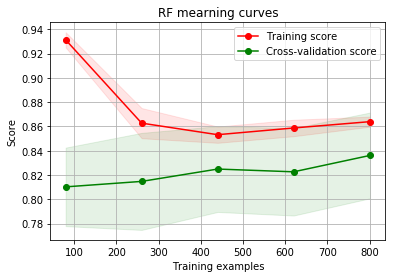

In [289]:
if config.get("show_visual"):
    g = plot_learning_curve(rfc,"RF mearning curves",X_train,Y_train,cv=kfold)

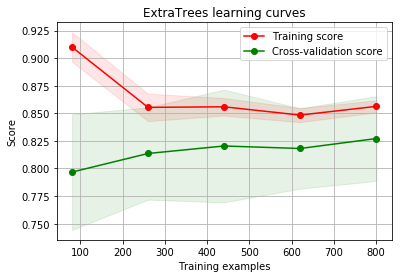

In [290]:
if config.get("show_visual"):
    g = plot_learning_curve(etc,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)

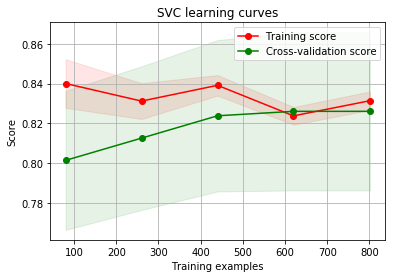

In [291]:
if config.get("show_visual"):
    g = plot_learning_curve(svc,"SVC learning curves",X_train,Y_train,cv=kfold)

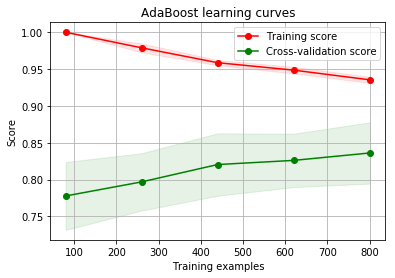

In [292]:
if config.get("show_visual"):
    g = plot_learning_curve(ada,"AdaBoost learning curves",X_train,Y_train,cv=kfold)

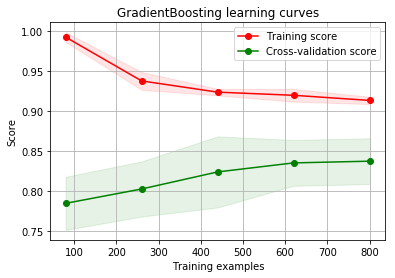

In [293]:
if config.get("show_visual"):
    g = plot_learning_curve(gbc,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

本地执行不起来<br>
`g = plot_learning_curve(mlp,"MLP learning curves",X_train,Y_train,cv=kfold)`<br>
Kaggle上执行结果如图<br>
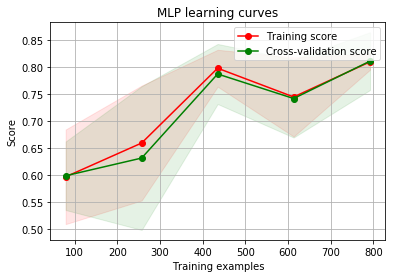

### result:
Adaboost and GradientBoost seems overfit<br>
RandomForest and ExtraTrees and SVM and MLP seem to better generalize the prediction since the training and cross-validation curves are close together.

# Feature importance

In [294]:
def plt_feature_importance(classifier, name):
    fig, axes = plt.subplots(nrows=1, ncols=1, sharex="all", figsize=(10,10))
    indices = np.argsort(classifier.feature_importances_)[::-1][:40]
    XX = dataall.iloc[:train_len].drop("Survived", axis=1)
    g = sb.barplot(
        y=XX.columns[indices][:40], 
        x=classifier.feature_importances_[indices][:40], 
        orient='h')
    g.set_xlabel("Relative importance", fontsize=12)
    g.set_ylabel("Features", fontsize=12)
    g.tick_params(labelsize=9)
    g.set_title(name + " feature importance")

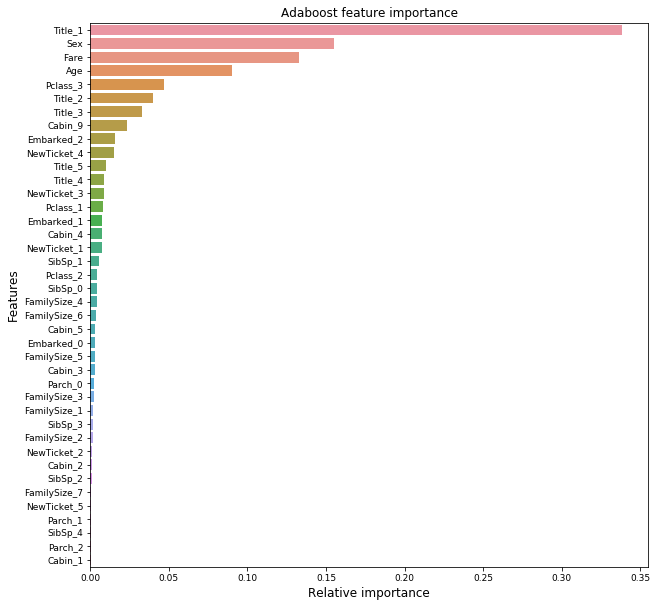

In [295]:
# if config.get("show_visual"):
#     plt_feature_importance(ada, "Adaboost")

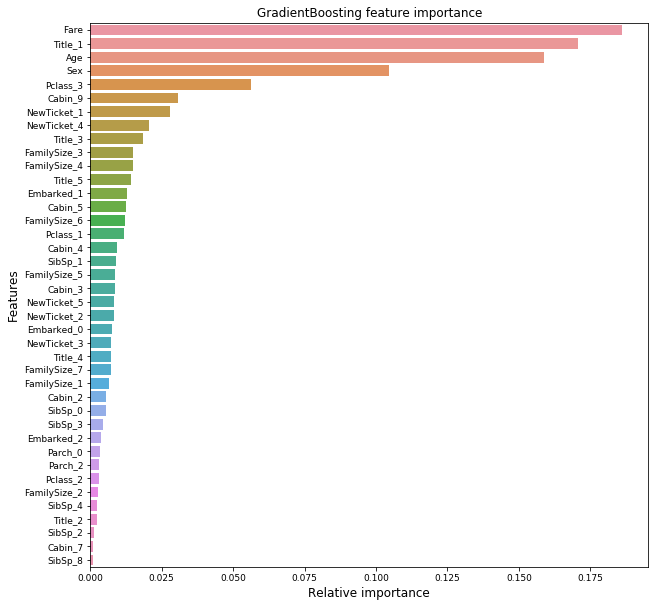

In [296]:
# if config.get("show_visual"):
#     plt_feature_importance(gbc, "GradientBoosting")

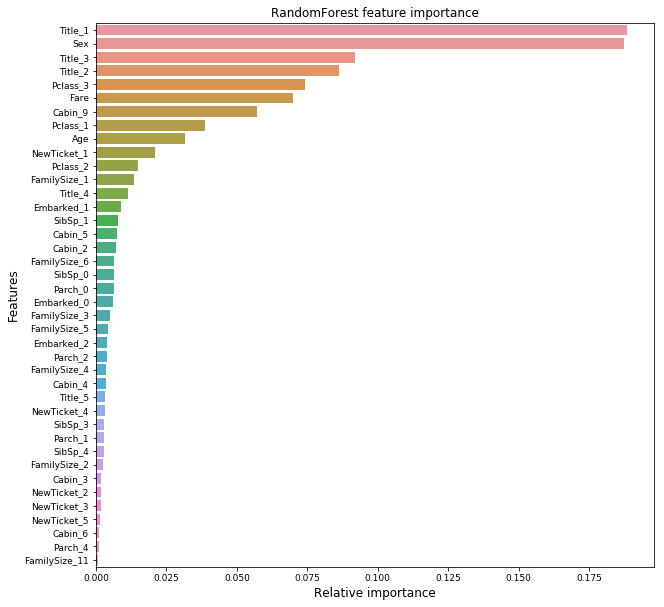

In [297]:
if config.get("show_visual"):
    plt_feature_importance(rfc, "RandomForest")

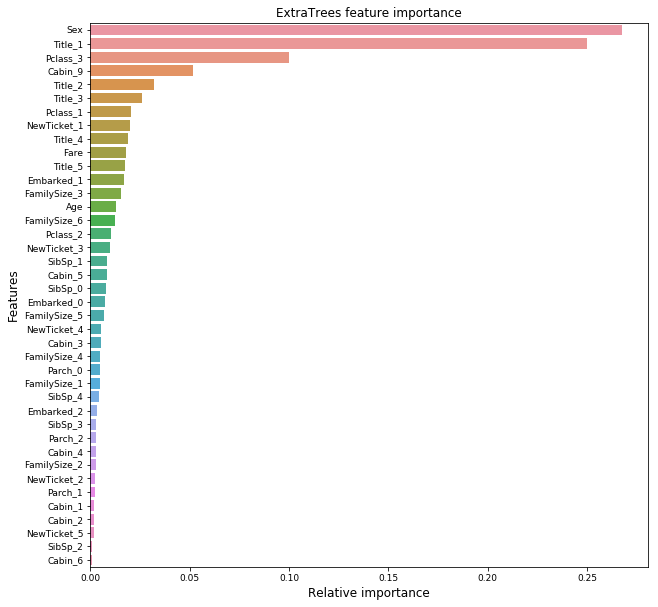

In [298]:
# if config.get("show_visual"):
#     plt_feature_importance(etc, "ExtraTrees")

# Finally, Predict

In [299]:
test_Survived_RFC = pd.Series(rfc.predict(X_test), name="RandomForest")
test_Survived_ExtC = pd.Series(etc.predict(X_test), name="ExtraTrees")
test_Survived_SVMC = pd.Series(svc.predict(X_test), name="SVM")
test_Survived_AdaC = pd.Series(ada.predict(X_test), name="Adaboost")
test_Survived_GBC = pd.Series(gbc.predict(X_test), name="GradientBoosting")
test_Survived_MLP = pd.Series(mlp.predict(X_test), name="MLP")

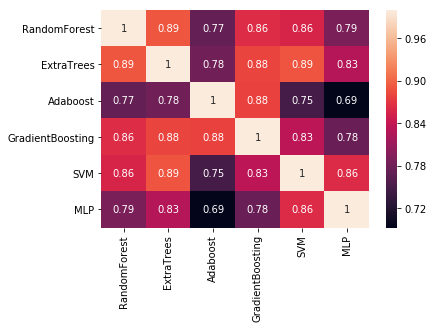

In [301]:
ensemble_results = pd.concat([
    test_Survived_RFC,
    test_Survived_ExtC,
    test_Survived_AdaC,
    test_Survived_GBC, 
    test_Survived_SVMC,
    test_Survived_MLP,
],axis=1)
if config.get("show_visual"):
    g = sb.heatmap(ensemble_results.corr(), annot=True)

In [302]:
vc = VotingClassifier(
    estimators=[
        ('rfc', rfc), 
        ('etc', etc),
        ('svc', svc), 
        ('ada', ada),
        ('gbc', gbc),
        ("mlp", mlp),
    ], 
    voting='hard', 
#     weights=[1,1,2,1,1,2],
    n_jobs=CORE_COUNT)

vc = vc.fit(X_train, Y_train)

In [303]:
prediction = vc.predict(X_test)
# print(prediction)
results = pd.DataFrame({
    'PassengerId': np.arange(ttrain.shape[0] + 1, ttrain.shape[0] + prediction.shape[0] + 1), 
    'Survived': prediction.squeeze() })
results.to_csv("ensemble_python_voting.csv", index=False)

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## 结果
voting="soft"，结果没有超过0.79<br>
voting="hard"，结果接近0.8<br>
使用mlp代替gbc，结果并没有提升<br>
将mlp直接加入，结果依然没有提升